In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1740168187.307817   58498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740168187.311583   58498 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740168188.962351   58498 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
df_train = pd.read_csv("../Datasets/trainSet.csv")
df_train = df_train.iloc[:,1:]

df_test = pd.read_csv("../Datasets/testSet.csv")
df_test = df_test.iloc[:,1:]

df = pd.concat([df_train, df_test])

print("Dimensão dos dados de treino: {}".format(df_train.shape))
print("Dimensão dos dados de teste: {}".format(df_test.shape))
print("Dimensão dos dados completos: {}".format(df.shape))

mri = np.load("../Datasets/mri.npz")

mriTrain = (mri["train_images"] / np.max(mri["train_images"]))
# mriTrain = mri["train_images"]
# Remove uma observação do conjunto, que contava com dados de especificação faltantes
mriTrain = np.delete(mriTrain, 230, axis=0)

mriTest = (mri["test_images"] / np.max(mri["test_images"]))
# mriTest = mri["test_images"]

image_dim = mriTrain[0].shape
print("Dimensão das imagens: {}".format(image_dim))

x_train = mriTrain
t_train = df_train.time.to_numpy()
delta_train = df_train.delta.to_numpy()
m_train = df_train.delta.to_numpy()
x_test = mriTest
t_test = df_test.time.to_numpy()
delta_test = df_test.delta.to_numpy()
m_test = df_test.delta.to_numpy()

Dimensão dos dados de treino: (280, 23)
Dimensão dos dados de teste: (72, 23)
Dimensão dos dados completos: (352, 23)
Dimensão das imagens: (160, 200, 1)


# Definição do modelo

In [36]:
# from custom_model import *

In [4]:
# # Funções traduzidas para o treinamento da rede neural - Poisson
# log_a_poisson = lambda x : -tf.math.lgamma(x+1)
# log_phi_poisson = lambda theta : tf.math.log(theta)
# C_poisson = lambda theta : tf.math.exp(theta)
# C_inv_poisson = lambda x : tf.math.log(x)
# B_poisson = 101
# sup_poisson = "np.arange(0, B_poisson, 1).astype(np.float64)"
# log_a_poisson_str = "lambda x : -tf.math.lgamma(x+1)"
# log_phi_poisson_str = "lambda theta : tf.math.log(theta)"
# C_poisson_str = "lambda theta : tf.math.exp(theta)"
# C_inv_poisson_str = "lambda x : tf.math.log(x)"
# B_poisson_str = "101"
# sup_poisson_str = "np.arange(0, B, 1).astype(np.float64)"

In [5]:
# poisson_model = MPScrModel(log_a_poisson, log_phi_poisson, C_poisson, C_inv_poisson, sup_poisson)
# poisson_model.define_structure(shape_input = x_train[0].shape)
# poisson_model.summary()

/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740167378.309158   34352 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1740167378.930261   34352 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "mp_scr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (1, 160, 200, 4)       │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 80, 100, 12)       │         1,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 40, 50, 32)        │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (1, 16000)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │     2,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │           128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,059,204 (7.86 MB)

 Trainable params: 2,059,204 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do modelo

In [10]:
# alpha0, s_t = initialize_alpha_s(t_train, n_cuts = 5)
# s_t = np.array([0.0, 2.062, 3.36, 4.495, 6.32, 12.2])

# print("alpha0: {}".format(alpha0))
# print("cuts: {}".format(s_t))

alpha0: [1. 1. 1. 1. 1. 1.]
cuts: [ 0.     2.062  3.36   4.495  6.32  12.2  ]


In [7]:
# # alpha_xie = np.array([0.028723076, 0.048700187, 0.10390695, 0.16946955, 0.5868493, 1.0])
# # alpha0 = alpha_xie.copy()

# set_all_seeds(10)
# poisson_model = MPScrModel(log_a_poisson, log_phi_poisson, C_poisson, C_inv_poisson, sup_poisson)
# poisson_model.define_structure(shape_input = x_train[0].shape)
# # print(img_model_poisson.get_weights()[0][0])
# # print(img_model_poisson.predict(x_train, verbose = False).flatten())

# results = call_EM("EM.py",
#                   log_a_poisson_str, log_phi_poisson_str, C_poisson_str, C_inv_poisson_str, B_poisson_str, sup_poisson_str,
#                   poisson_model, alpha0, s_t,
#                   x_train, t_train, delta_train, delta_train,
#                   max_iterations = 60,
#                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
#                   epochs = 100, batch_size = 64, shuffle = True,
#                   learning_rate = 0.001, run_eagerly = False,
#                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
#                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
#                   validation = True,
#                   x_val = x_test, t_val = t_test, delta_val = delta_test, m_val = delta_test,
#                   verbose = 3, alpha_known = False)

E0000 00:00:1740167380.042539   34490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740167380.045998   34490 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740167382.163304   34490 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3972 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1740167382.281382   34490 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3972 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `inpu

Iniciando passo 1


I0000 00:00:1740167384.156896   34562 service.cc:148] XLA service 0x7c2534005220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740167384.156954   34562 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1740167388.091052   34562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
 16%|█▌        | 16/100 [00:10<00:54,  1.55epoch/s, loss=0.419, loss_val=0.537]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 5.9907080490142555e-06
Distância Parâmetros Alpha: 0.39179786441162995
Média das distâncias: 0.19590192755983948
Iniciando passo 2


  7%|▋         | 7/100 [00:03<00:47,  1.96epoch/s, loss=0.515, loss_val=0.616]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.6544040607754863e-06
Distância Parâmetros Alpha: 0.0021952056642063292
Média das distâncias: 0.0010984300341335524
Iniciando passo 3


  8%|▊         | 8/100 [00:04<00:50,  1.84epoch/s, loss=0.671, loss_val=0.696]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 5.798723802763154e-06
Distância Parâmetros Alpha: 0.0022763340992361185
Média das distâncias: 0.0011410664115194407
Iniciando passo 4


 15%|█▌        | 15/100 [00:05<00:30,  2.76epoch/s, loss=0.625, loss_val=0.767]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.377449548056619e-06
Distância Parâmetros Alpha: 0.0034976152959809493
Média das distâncias: 0.001750996372764503
Iniciando passo 5


 14%|█▍        | 14/100 [00:05<00:31,  2.75epoch/s, loss=0.612, loss_val=0.757]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 5.269935436951904e-06
Distância Parâmetros Alpha: 0.0007512567945016673
Média das distâncias: 0.0003782633649693096
Iniciando passo 6


 10%|█         | 10/100 [00:04<00:37,  2.40epoch/s, loss=0.767, loss_val=0.785]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.168280003032721e-06
Distância Parâmetros Alpha: 0.0004664446249852689
Média das distâncias: 0.0002353064524941508
Iniciando passo 7


  6%|▌         | 6/100 [00:03<00:55,  1.70epoch/s, loss=0.81, loss_val=0.801] 


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 6.712155272813652e-07
Distância Parâmetros Alpha: 0.0005271433021557952
Média das distâncias: 0.0002639072588415383
Iniciando passo 8


 13%|█▎        | 13/100 [00:04<00:32,  2.65epoch/s, loss=0.72, loss_val=0.824] 


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.593785342232322e-06
Distância Parâmetros Alpha: 0.0005474321960453804
Média das distâncias: 0.00027601299069380635
Iniciando passo 9


  6%|▌         | 6/100 [00:03<00:53,  1.77epoch/s, loss=0.892, loss_val=0.819]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 8.314671835135164e-07
Distância Parâmetros Alpha: 8.032140131643128e-05
Média das distâncias: 4.05764342499724e-05
Iniciando passo 10


  8%|▊         | 8/100 [00:03<00:44,  2.07epoch/s, loss=0.847, loss_val=0.84] 


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 3.5305046105011237e-06
Distância Parâmetros Alpha: 0.00024024852448425494
Média das distâncias: 0.00012188951454737804
Learning rate reduzida para 0.0001
Iniciando passo 11


  6%|▌         | 6/100 [00:03<00:52,  1.79epoch/s, loss=0.9, loss_val=0.835]  


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 3.0880400341875286e-09
Distância Parâmetros Alpha: 4.858227446713989e-05
Média das distâncias: 2.4292681253587038e-05
Iniciando passo 12


  9%|▉         | 9/100 [00:04<00:40,  2.24epoch/s, loss=0.815, loss_val=0.84] 


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.275090419037877e-07
Distância Parâmetros Alpha: 2.0322399984071427e-05
Média das distâncias: 1.0224954512987607e-05
Iniciando passo 13


  7%|▋         | 7/100 [00:03<00:48,  1.93epoch/s, loss=0.883, loss_val=0.852]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 3.539992801568851e-08
Distância Parâmetros Alpha: 2.637743042722119e-05
Média das distâncias: 1.3206415177618439e-05
Iniciando passo 14


  7%|▋         | 7/100 [00:03<00:47,  1.95epoch/s, loss=0.806, loss_val=0.863]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.840132385541297e-08
Distância Parâmetros Alpha: 3.1573223358184125e-05
Média das distâncias: 1.5810812341019768e-05
Iniciando passo 15


  6%|▌         | 6/100 [00:03<00:54,  1.74epoch/s, loss=0.866, loss_val=0.865]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 7.567414450576242e-09
Distância Parâmetros Alpha: 7.10471738757976e-06
Média das distâncias: 3.556142401015168e-06
Iniciando passo 16


  6%|▌         | 6/100 [00:03<00:54,  1.73epoch/s, loss=0.744, loss_val=0.861]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 3.985261298856721e-09
Distância Parâmetros Alpha: 2.2991384524602244e-07
Média das distâncias: 1.1694955327243958e-07
Algoritmo convergiu após 16 iterações. Retornando.


/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Número de arquivos no diretório: 16


alpha estimado: [0.0416439  0.0773185  0.11681997 0.11095238 0.16378548 1.        ]
alpha xie: [0.01570256 0.04739518 0.09240146 0.13731525 0.43543998 1.        ]


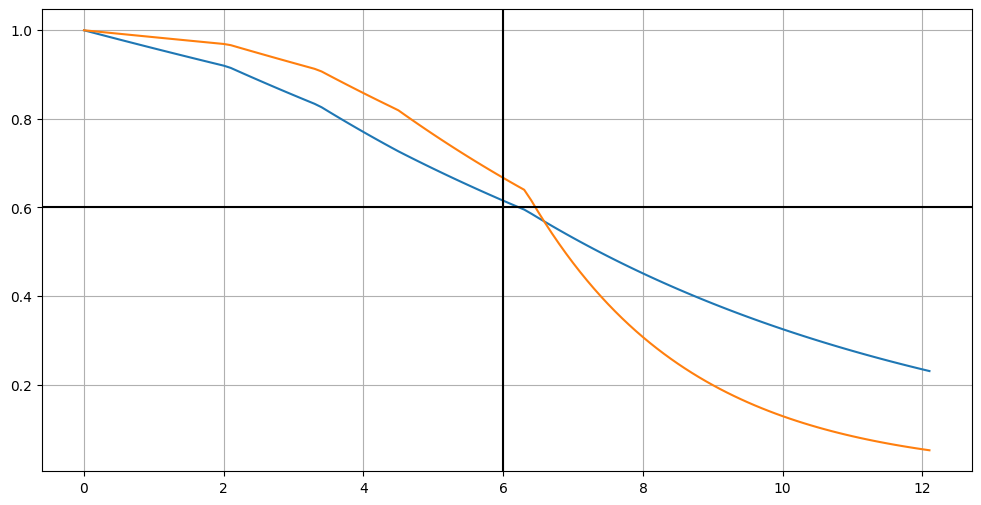

In [10]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, results["alpha_history"][-1], s_t)

alpha_xie = np.array([0.01570256, 0.04739518, 0.09240146, 0.13731525, 0.43543998, 1.])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.axhline(0.6, color = "black")
plt.axvline(6, color = "black")
plt.grid()
plt.show()

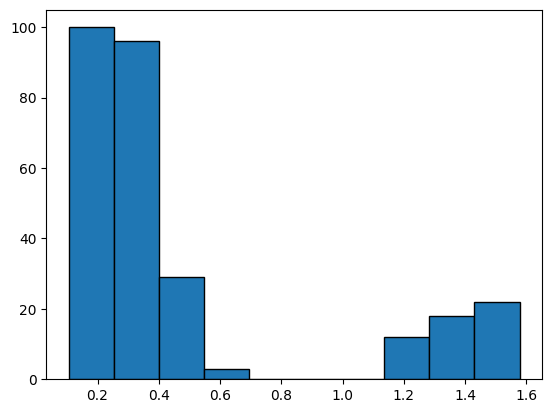

In [9]:
plt.hist(results["m_history"][-1], edgecolor = "black")
plt.show()

# Simulação

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

In [4]:
def load_file(data_dir, file_index, distribution, train_images, test_images):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            file_index = 20
            distribution = "poisson"
    '''
    index_path = "{}/indices_{}.csv".format(data_dir, file_index, distribution)
    data_path = "{}/{}/data_{}.csv".format(data_dir, distribution, file_index)
    df_index = pd.read_csv(index_path)
    df_data = pd.read_csv(data_path)

    index_train = df_index.loc[df_index.set == "train","index"].to_numpy()
    index_val = df_index.loc[df_index.set == "val","index"].to_numpy()
    index_test = df_index.loc[df_index.set == "test","index"].to_numpy()

    # Values for the thetas
    theta_train = df_data.loc[df_data.set == "train", "theta"]
    theta_val = df_data.loc[df_data.set == "val", "theta"]
    theta_test = df_data.loc[df_data.set == "test", "theta"]
    # Values for the latent variable
    m_train = df_data.loc[df_data.set == "train", "m"]
    m_val = df_data.loc[df_data.set == "val", "m"]
    m_test = df_data.loc[df_data.set == "test", "m"]
    # Values for the time variable
    t_train = df_data.loc[df_data.set == "train", "t"]
    t_val = df_data.loc[df_data.set == "val", "t"]
    t_test = df_data.loc[df_data.set == "test", "t"]
    # Values for the censorship indicators
    delta_train = df_data.loc[df_data.set == "train", "delta"]
    delta_val = df_data.loc[df_data.set == "val", "delta"]
    delta_test = df_data.loc[df_data.set == "test", "delta"]

    img_train = train_images[index_train,:,:]
    img_val = train_images[index_val,:,:]
    img_test = test_images[index_test,:,:]

    result = {
        "theta_train": theta_train, "theta_val": theta_val, "theta_test": theta_test,
        "m_train": m_train, "m_val": m_val, "m_test": m_test,
        "t_train": t_train, "t_val": t_val, "t_test": t_test,
        "delta_train": delta_train, "delta_val": delta_val, "delta_test": delta_test,
        "img_train": img_train, "img_val": img_val, "img_test": img_test,
        "index_train": index_train, "index_val": index_val, "index_test": index_test
    }
    
    return result

In [5]:
import os, shutil
from pathlib import Path

print("Creating directories structure")
dists_scenario1 = ["poisson", "logarithmic", "geometric", "mvnb2", "bernoulli", "bin5"]
dists_scenario2 = ["borel", "rgp2", "rgp10", "haight", "geeta3"]
for dist in dists_scenario1:
    Path("SimulationResults/Scenario1/n500/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario1/n1000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario1/n3000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
for dist in dists_scenario2:
    Path("SimulationResults/Scenario2/n500/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario2/n1000/{}".format(dist)).mkdir(parents=True, exist_ok=True)
    Path("SimulationResults/Scenario2/n3000/{}".format(dist)).mkdir(parents=True, exist_ok=True)

Creating directories structure


In [38]:
def fit_simulation(distribution,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   q = None,
                   batch_size = None,
                   seed = 1):
    set_all_seeds(seed)
    
    alpha0, s_t = initialize_alpha_s(t_train, n_cuts = 5)
    
    if(distribution == "poisson"):
        log_a_tf = log_a_poisson_tf
        log_phi_tf = log_phi_poisson_tf
        C_tf = C_poisson_tf
        C_inv_tf = C_inv_poisson_tf
        sup = sup_poisson
        
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        B_str = "10001"
    elif(distribution == "logarithmic"):
        log_a_tf = log_a_log_tf
        
        log_phi_tf = log_phi_log_tf
        C_tf = C_log_tf
        C_inv_tf = C_inv_log_tf
        sup = sup_log
        
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        B_str = "10001"
    elif(distribution == "nb"):
        if(q is None):
            raise("Please, specify the fixed parameter (q) for the distribution.")
        log_a_tf = log_a_mvnb_tf
        log_phi_tf = log_phi_mvnb_tf
        C_tf = C_mvnb_tf
        C_inv_tf = C_inv_mvnb_tf
        sup = sup_mvnb
        
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        B_str = "10001"
        
    mps_model = MPScrModel(log_a_tf, log_phi_tf, C_tf, C_inv_tf, sup)
    mps_model.define_structure(shape_input = img_train[0].shape)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, B_str, sup_str,
                      mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = 60,
                      early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                      epochs = 100, batch_size = 64, shuffle = True,
                      learning_rate = 0.001, run_eagerly = True,
                      early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                      reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = 3, alpha_known = False)
    return results

In [7]:
fake_file_info = {
    'theta_train': None,
    'theta_val': None,
    'theta_test': None,
    'm_train': None,
    'm_val': None,
    'm_test': None,
    't_train': t_train,
    't_val': t_test,
    't_test': t_test,
    'delta_train': delta_train,
    'delta_val': delta_test,
    'delta_test': delta_test,
    'img_train': x_train,
    'img_val': x_test,
    'img_test': x_test,
    'index_train': None,
    'index_val': None,
    'index_test': None
}

In [8]:
set_all_seeds(10)

sim_results = fit_simulation("logarithmic",
               fake_file_info["t_train"], fake_file_info["t_val"],
               fake_file_info["delta_train"], fake_file_info["delta_val"],
               fake_file_info["img_train"], fake_file_info["img_val"],
               batch_size = None,
               seed = 1)

[ 0.          3.18191781  4.9769863   7.06246575  9.13643836 12.11780822]


/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740168208.052226   58498 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1740168208.581582   58498 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1740168209.543126   58623 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740168209.546727   58623 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory 

Iniciando passo 1


  6%|▌         | 6/100 [00:06<01:49,  1.16s/epoch, loss=0.619, loss_val=0.516]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 7.465551459531171e-06
Distância Parâmetros Alpha: 0.39179786441162995
Média das distâncias: 0.19590266498154474
Iniciando passo 2


  9%|▉         | 9/100 [00:02<00:29,  3.13epoch/s, loss=0.485, loss_val=0.53] 


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.725458423316999e-06
Distância Parâmetros Alpha: 7.067763709093147e-05
Média das distâncias: 3.620154775712423e-05
Iniciando passo 3


  7%|▋         | 7/100 [00:02<00:29,  3.15epoch/s, loss=0.655, loss_val=0.629]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 3.4073414922714043e-07
Distância Parâmetros Alpha: 0.0020994030964094934
Média das distâncias: 0.0010498719152793603
Iniciando passo 4


  7%|▋         | 7/100 [00:02<00:29,  3.12epoch/s, loss=0.639, loss_val=0.665]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 6.318434215649649e-07
Distância Parâmetros Alpha: 0.0009045677011126608
Média das distâncias: 0.00045259977226711287
Iniciando passo 5


 12%|█▏        | 12/100 [00:03<00:27,  3.15epoch/s, loss=0.568, loss_val=0.757]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.8080761274559676e-06
Distância Parâmetros Alpha: 0.0031466037067331165
Média das distâncias: 0.0015742058914302863
Iniciando passo 6


 24%|██▍       | 24/100 [00:07<00:24,  3.13epoch/s, loss=0.635, loss_val=0.762]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 2.107563363120754e-05
Distância Parâmetros Alpha: 0.0007595890055129015
Média das distâncias: 0.00039033231957205454
Iniciando passo 7


  6%|▌         | 6/100 [00:01<00:29,  3.15epoch/s, loss=0.603, loss_val=0.775]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 2.346075230756216e-06
Distância Parâmetros Alpha: 0.00025188113005481633
Média das distâncias: 0.00012711360264278627
Iniciando passo 8


  8%|▊         | 8/100 [00:02<00:29,  3.13epoch/s, loss=0.844, loss_val=0.785]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.742767975472936e-06
Distância Parâmetros Alpha: 0.0004876564365966715
Média das distâncias: 0.0002461996022860722
Iniciando passo 9


 10%|█         | 10/100 [00:03<00:29,  3.07epoch/s, loss=0.839, loss_val=0.809]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 4.528055351821983e-06
Distância Parâmetros Alpha: 0.0005246735851832257
Média das distâncias: 0.0002646008202675238
Iniciando passo 10


  7%|▋         | 7/100 [00:02<00:30,  3.09epoch/s, loss=0.622, loss_val=0.843]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.288383558679304e-06
Distância Parâmetros Alpha: 0.0005659032081922335
Média das distâncias: 0.0002835957958754564
Learning rate reduzida para 0.0001
Iniciando passo 11


  0%|          | 0/100 [00:00<?, ?epoch/s]

Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.4579784912216637e-08
Distância Parâmetros Alpha: 0.00024091204304780203
Média das distâncias: 0.00012046331141635713
Iniciando passo 12


  6%|▌         | 6/100 [00:01<00:28,  3.27epoch/s, loss=0.787, loss_val=0.823]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 1.5026168669511196e-08
Distância Parâmetros Alpha: 5.125989355917148e-05
Média das distâncias: 2.5637459863920495e-05
Iniciando passo 13


  6%|▌         | 6/100 [00:01<00:29,  3.24epoch/s, loss=0.752, loss_val=0.809]


Iniciando treinamento:
Tamanho da amostra de treino: 280
Tamanho da amostra de validação: 72
Distância Parâmetros Rede Neural: 9.56259715680197e-09
Distância Parâmetros Alpha: 1.1341003181529093e-06
Média das distâncias: 5.718314576548556e-07
Algoritmo convergiu após 13 iterações. Retornando.


/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Número de arquivos no diretório: 13


alpha estimado: [0.04274537 0.08251279 0.12731988 0.13075798 0.21122608 1.        ]
alpha xie: [0.01570256 0.04739518 0.09240146 0.13731525 0.43543998 1.        ]


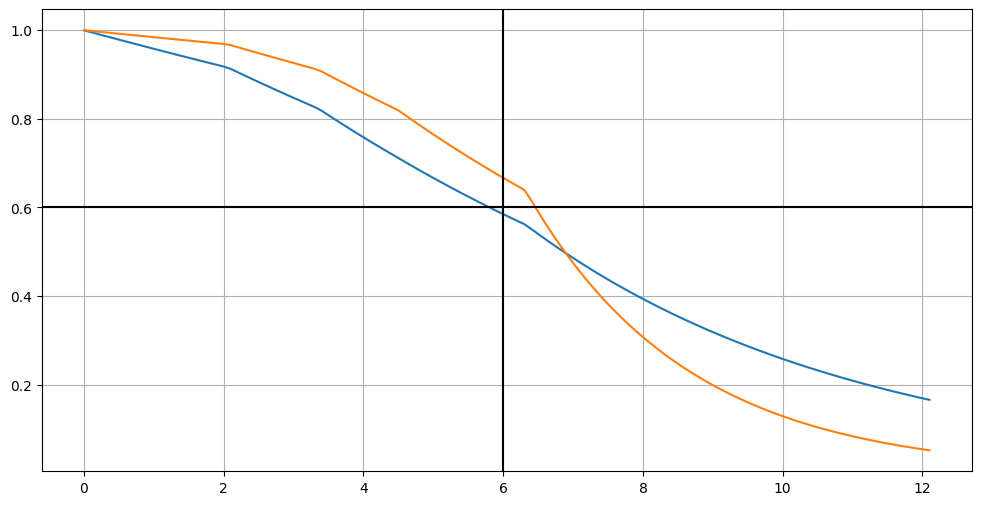

In [11]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([0.01570256, 0.04739518, 0.09240146, 0.13731525, 0.43543998, 1.])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.axhline(0.6, color = "black")
plt.axvline(6, color = "black")
plt.grid()
plt.show()

In [37]:
file_info = load_file("SimulationDataset/Scenario1/n3000/", 1, "logarithmic", train_images, test_images)
print( "Keys: {}".format(list(file_info.keys())) )

Keys: ['theta_train', 'theta_val', 'theta_test', 'm_train', 'm_val', 'm_test', 't_train', 't_val', 't_test', 'delta_train', 'delta_val', 'delta_test', 'img_train', 'img_val', 'img_test', 'index_train', 'index_val', 'index_test']


In [39]:
set_all_seeds(10)

sim_results = fit_simulation("logarithmic",
               file_info["t_train"], file_info["t_val"],
               file_info["delta_train"], file_info["delta_val"],
               file_info["img_train"], file_info["img_val"],
               batch_size = None,
               seed = 1)

NameError: name 'log_a_log_str' is not defined

alpha estimado: [0.98001261 0.89815018 1.30820455 0.65660689 1.         1.        ]
alpha xie: [1 1 1 1 1 1]


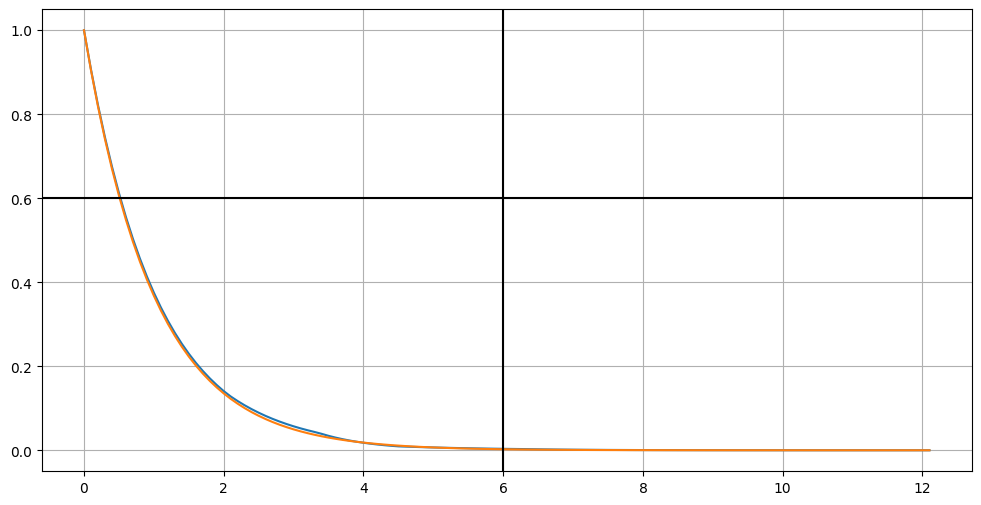

In [33]:
tv = np.arange(0, s_t[-1], 0.1)
S1v = S1(tv, sim_results["alpha_history"][-1], s_t)

alpha_xie = np.array([1, 1, 1, 1, 1, 1])
S1v_xie = S1(tv, alpha_xie, s_t)

print("alpha estimado: {}".format(sim_results["alpha_history"][-1]))
print("alpha xie: {}".format(alpha_xie))

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(tv, S1v)
plt.plot(tv, S1v_xie)
plt.axhline(0.6, color = "black")
plt.axvline(6, color = "black")
plt.grid()
plt.show()

In [34]:
eta_pred_train = sim_results["new_model"].predict(file_info["img_train"])
eta_pred_test = sim_results["new_model"].predict(file_info["img_test"])

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step    
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [35]:
file_info["m_train"]

0       0
1       0
2       0
3       1
4       5
       ..
2995    1
2996    0
2997    2
2998    0
2999    0
Name: m, Length: 3000, dtype: int64